# 1. Data

In [1]:
# loading necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('thl_recoded.csv')
data.head()

,kannabis,alcohol_use,nuuska,cigarette,e_cigarette,prob_country,prob_resident,risk_of_use,risk_of_try,cannabis_access,...,household_1.0,household_2.0,household_3.0,drug_punishment_1.0,drug_punishment_2.0,drug_punishment_3.0,drug_punishment_4.0,violence_treat_1.0,violence_treat_2.0,violence_treat_3.0
0,0.0,3.0,1.0,1.0,1.0,3.0,2.0,24.0,13.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,1.0,1.0,1.0,3.0,2.0,23.0,17.0,3.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,5.0,1.0,2.0,1.0,4.0,3.0,24.0,18.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1.0,7.0,2.0,2.0,1.0,3.0,2.0,22.0,12.0,3.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,5.0,1.0,1.0,1.0,3.0,2.0,24.0,16.0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [3]:
 # Kannabis use
data['kannabis'].value_counts(normalize= True)

0.0    0.914525
1.0    0.085475
Name: kannabis, dtype: float64

## 1.1. Combination of Over- and Under-sampling/ Hybrid Methods

In the previous stage, we learned that the best sampling strategy for this data set is hybrit method. For that reason, we will continue with this method for the rest of the re-sampling processes.  

In [4]:
# resample by adding samples to minority class using SMOTE
from collections import Counter
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

from sklearn.model_selection import train_test_split
X, y = data.iloc[:, 1:].values, data.iloc[:, 0].values

resample = SMOTETomek(tomek=TomekLinks(sampling_strategy='not majority'))
X_oversamp, Y_over_samp = resample.fit_resample(X, y)



#split data train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_oversamp,
                                                    Y_over_samp,
                                                    test_size=0.3,
                                                    random_state = 10)



print(f"Class counts after resampling {Counter( Y_over_samp)}")

Class counts after resampling Counter({0.0: 2953, 1.0: 2953})


In [5]:
# Scaling
from sklearn.preprocessing import RobustScaler

robust = RobustScaler()
X_train_std = robust.fit_transform(X_train)
X_test_std = robust.transform(X_test)

# 2. Selecting best classifier with RFEVC
This is a fast method to check which classifier works better. RFECV determines number of features automatically, so in this stage, we are not interested in how many features are in the model, instead, which model produce higer accuracy rate. Since it is an unbalanced data, I will use f1 score for model performance. 

Xboost changed its algorithms, I do not have time to fix it here, so I just muted it. 

In [6]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.pipeline import Pipeline


# create pipeline of differennt base algorithms to be used in RFECV 
# (no. of features will be auto-selected based on cv in RFECV)
models = {}
# logistic regression
rfecv = RFECV(estimator = LogisticRegression(solver='lbfgs', max_iter=1000), cv = 2, scoring = 'f1_macro')
model = DecisionTreeClassifier()
models['LR'] = Pipeline(steps = [('features', rfecv), ('model', model)])
# decision tree
rfecv = RFECV(estimator = DecisionTreeClassifier(), cv = 5, scoring = 'f1_macro')
model = DecisionTreeClassifier()
models['DT'] = Pipeline(steps = [('features', rfecv), ('model', model)])
# random forest
rfecv = RFECV(estimator = RandomForestClassifier(), cv = 5, scoring = 'f1_macro')
model = DecisionTreeClassifier()
models['RF'] = Pipeline(steps = [('features', rfecv), ('model', model)])

# XGBoost Classifier
#rfecv = RFECV(estimator=XGBClassifier(), cv = 2, scoring = 'accuracy')
#model = DecisionTreeClassifier()
#models['XGB'] = Pipeline(steps = [('features', rfecv), ('model', model)])


# Gradient Boosting Classifier
rfecv = RFECV(estimator=GradientBoostingClassifier(), cv = 5, scoring = 'f1_macro')
model = DecisionTreeClassifier()
models['GBC'] = Pipeline(steps = [('features', rfecv), ('model', model)])

# Perceptron
rfecv = RFECV(estimator=Perceptron(), cv = 5, scoring = 'f1_macro')
model = DecisionTreeClassifier()
models['PER'] = Pipeline(steps = [('features', rfecv), ('model', model)])


# SCV - default rbf
rfecv = RFECV(estimator= SVC(kernel='linear'), cv = 5, scoring = 'f1_macro')
model = DecisionTreeClassifier()
models['SVC'] = Pipeline(steps = [('features', rfecv), ('model', model)])


# evaluate all the models
results = []
names = []
for name, model in models.items():
    cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 5, random_state = 1)
    scores = cross_val_score(model, X_train_std, y_train, scoring = 'accuracy', cv = cv, n_jobs = -1)
    results.append(scores)
    names.append(name)
    print('>%s: %.3f' % (name, np.mean(scores)))

>LR: 0.945
>DT: 0.942
>RF: 0.945
>GBC: 0.944
>PER: 0.942
>SVC: 0.943


**Summary:** Results show that GBC, RF and LR models have a higher f1 score on feature elimination. However, we do not know yet how many features the models used to produce these resutls. 

## 2.1. RFE Classifier with a given number of features

In this stage, we can give a predetermined feature size and look for model performances. Put differently, let's say if we want to use less than 20 features, which model have higher f1 scores. 

In [7]:

# explore the algorithm wrapped by RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from matplotlib import pyplot

In [8]:
# get a list of models to evaluate
def get_models():
    models = dict()
    # lr
    rfe = RFE(estimator=LogisticRegression(solver='lbfgs', max_iter=1000), n_features_to_select=15)
    model = DecisionTreeClassifier()
    models['lr'] = Pipeline(steps=[('s',rfe),('m',model)])
    # perceptron
    rfe = RFE(estimator=Perceptron(), n_features_to_select=20)
    model = DecisionTreeClassifier()
    models['per'] = Pipeline(steps=[('s',rfe),('m',model)])
    # cart
    rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=20)
    model = DecisionTreeClassifier()
    models['cart'] = Pipeline(steps=[('s',rfe),('m',model)])
    # rf
    rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=20)
    model = DecisionTreeClassifier()
    models['rf'] = Pipeline(steps=[('s',rfe),('m',model)])
    # gbm
    rfe = RFE(estimator=GradientBoostingClassifier(), n_features_to_select=20)
    model = DecisionTreeClassifier()
    models['gbm'] = Pipeline(steps=[('s',rfe),('m',model)])
    # SCV - default rbf
    rfe = RFE(estimator= SVC(kernel='linear'), n_features_to_select=20)
    model = DecisionTreeClassifier()
    models['SVC'] = Pipeline(steps = [('s',rfe),('m',model)])

    
    

    return models

In [9]:
# evaluate a give model using cross-validation
def evaluate_model(model, X_train_std, y_train):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
    scores = cross_val_score(model, X_train_std, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
    return scores

In [10]:
# get the models to evaluate
models = get_models()

>lr 0.947 (0.009)
>per 0.943 (0.008)
>cart 0.942 (0.007)
>rf 0.941 (0.006)
>gbm 0.946 (0.006)
>SVC 0.942 (0.007)


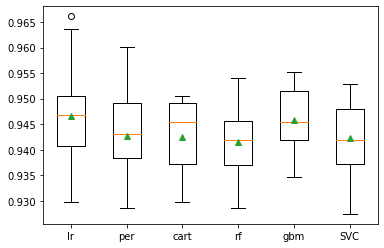

In [11]:
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train_std, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

**Summary:** The results show that GBM performs well with 15 features. 

# Select the minumum features

In this stage, we will look at more closely to the models, their performance and features they give importance. Here, we basically determine a model that works well for our expectations. 


In [12]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
import numpy as np


In [13]:
def feature_selection( X_train, X_test, y_train, y_test, model, estimator, n_split, n_repeat ):
    from sklearn.feature_selection import RFECV
    
    model_estimator = estimator
    

    
    #  RFECV model 
    rfecv = RFECV(estimator= model_estimator)
    model = model
    
    pipeline = Pipeline([('Feature Selection', rfecv), ('Model', model)])
    cv = RepeatedStratifiedKFold(n_splits=n_split, n_repeats=n_repeat, random_state=92116)
    n_scores = cross_val_score(pipeline, X_train, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
    np.mean(n_scores)
    

    # model fit 
    pipeline.fit(X_train, y_train)
    print('Optimal number of features : %d' % rfecv.n_features_)


    # Confusion matrix 
    y_pred = pipeline.predict(X_test)
    from sklearn import metrics
    from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import accuracy_score

    print('Accuracy:', np.round(metrics.accuracy_score(y_test, y_pred),4))
    print('Precision:', np.round(metrics.precision_score(y_test, y_pred,average='weighted'),4))
    print('Recall:', np.round(metrics.recall_score(y_test, y_pred,
                                               average='weighted'),4))
    print('F1 Score:', np.round(metrics.f1_score(y_test, y_pred,
                                               average='weighted'),4))
    print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, y_pred),4))
    print('Matthews Corrcoef:', np.round(metrics.matthews_corrcoef(y_test, y_pred),4)) 

    from sklearn.metrics import roc_auc_score
    print("roc_auc_score:", roc_auc_score(y_test, y_pred, average=None))

    print('\t\tClassification Report:\n', metrics.classification_report(y_pred,y_test))


    from sklearn.metrics import confusion_matrix
    print("Confusion Matrix:\n",confusion_matrix(y_test, y_pred))


    #Plot Confusion Matrix
    from sklearn.metrics import confusion_matrix
    from io import BytesIO #neded for plot
    import seaborn as sns; sns.set()
    import matplotlib.pyplot as plt

    mat = confusion_matrix(y_test, y_pred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)


    plt.xlabel('true label')
    plt.ylabel('predicted label');
    
    
    # Feature plot
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,6))
    plt.xlabel('Number of features selected')
    plt.ylabel('Cross validation score (nb of correct classifications)')
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    
    # List of features
    rfecv.support_rfecv_df = pd.DataFrame(rfecv.ranking_,index=data.columns[1:],columns=['Rank']).sort_values(by='Rank',ascending=True)

    dt_columns = rfecv.support_rfecv_df [rfecv.support_rfecv_df ['Rank']==1].reset_index()
    dt_columns = list(np.array(dt_columns['index']))
    

    

    return rfecv.support_rfecv_df
    
    
    


##  RFECV Gradient Boosting

Optimal number of features : 36
Accuracy: 0.9656
Precision: 0.9656
Recall: 0.9656
F1 Score: 0.9656
Cohen Kappa Score: 0.9311
Matthews Corrcoef: 0.9311
roc_auc_score: 0.9655269972676482
		Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.96      0.97       907
         1.0       0.96      0.97      0.96       865

    accuracy                           0.97      1772
   macro avg       0.97      0.97      0.97      1772
weighted avg       0.97      0.97      0.97      1772

Confusion Matrix:
 [[875  29]
 [ 32 836]]


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


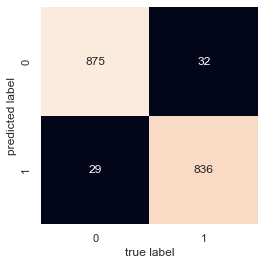

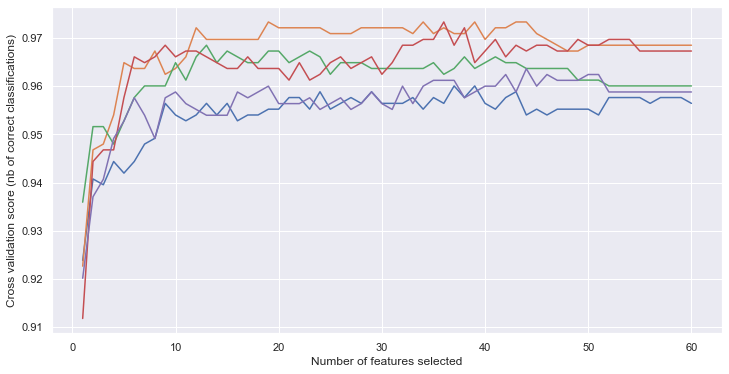

,Rank
alcohol_use,1
purchase_offer_1,1
residency_5.0,1
drug_punishment_4.0,1
employment_1,1
drug_punishment_3.0,1
violence_treat_2.0,1
drug_punishment_2.0,1
"age_bins_(24, 34]",1
drug_punishment_1.0,1


In [14]:
from sklearn.ensemble import GradientBoostingClassifier
estimator = GradientBoostingClassifier()
model = GradientBoostingClassifier()
# crosvalidation 
n_split = 5
n_repeat = 5


feature_selection(X_train_std, X_test_std, y_train, y_test, model, estimator,  n_split, n_repeat)

## RFECV SCV

Optimal number of features : 56
Accuracy: 0.9227
Precision: 0.9237
Recall: 0.9227
F1 Score: 0.9227
Cohen Kappa Score: 0.8455
Matthews Corrcoef: 0.8464
roc_auc_score: 0.9231245666979324
		Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.94      0.92       863
         1.0       0.94      0.90      0.92       909

    accuracy                           0.92      1772
   macro avg       0.92      0.92      0.92      1772
weighted avg       0.92      0.92      0.92      1772

Confusion Matrix:
 [[815  89]
 [ 48 820]]


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


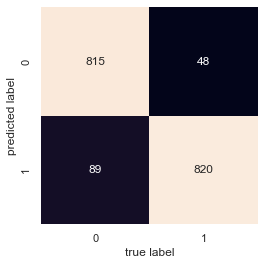

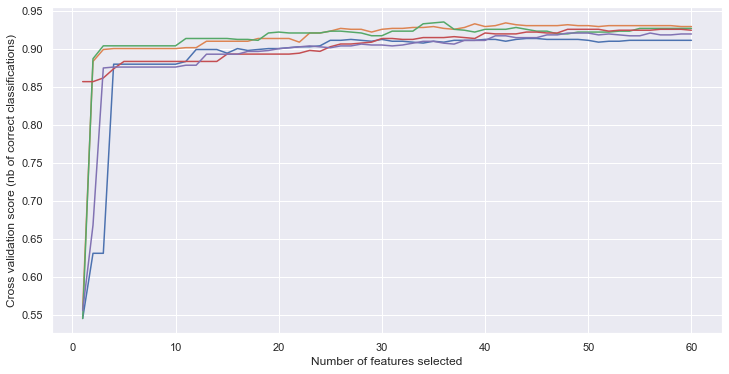

,Rank
alcohol_use,1
"age_bins_(24, 34]",1
"age_bins_(34, 44]",1
"age_bins_(44, 54]",1
"age_bins_(54, 70]",1
education_1.0,1
education_2.0,1
education_3.0,1
education_4.0,1
residency_1.0,1


In [15]:
from sklearn.svm import SVC

estimator =  SVC(kernel="linear", C=50)
model = SVC(kernel="linear", C= 50)

# crosvalidation 
n_split = 5
n_repeat = 5


feature_selection(X_train_std, X_test_std, y_train, y_test, model, estimator,  n_split, n_repeat)

## RFECV Randon Forest 

Optimal number of features : 36
Accuracy: 0.9712
Precision: 0.9712
Recall: 0.9712
F1 Score: 0.9712
Cohen Kappa Score: 0.9424
Matthews Corrcoef: 0.9424
roc_auc_score: 0.9711956078463359
		Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       905
         1.0       0.97      0.97      0.97       867

    accuracy                           0.97      1772
   macro avg       0.97      0.97      0.97      1772
weighted avg       0.97      0.97      0.97      1772

Confusion Matrix:
 [[879  25]
 [ 26 842]]


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


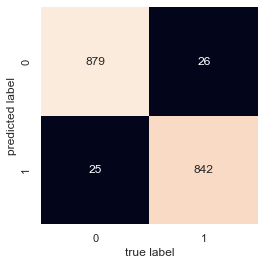

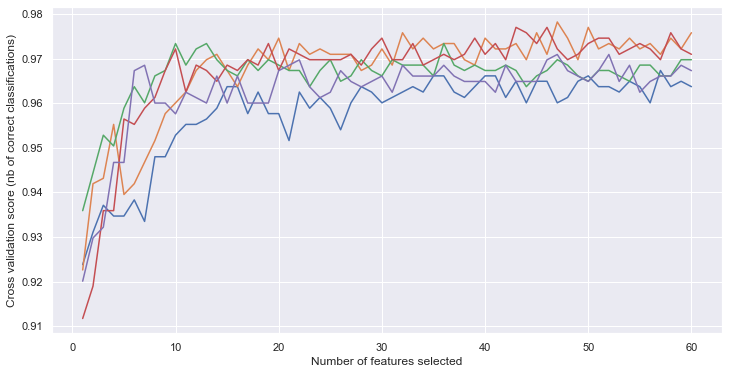

,Rank
alcohol_use,1
purchase_offer_1,1
violence_treat_2.0,1
"age_bins_(14, 24]",1
"age_bins_(24, 34]",1
education_4.0,1
residency_1.0,1
residency_2.0,1
free_offer_1,1
marriage_status_1.0,1


In [16]:
from sklearn.ensemble import RandomForestClassifier

estimator= RandomForestClassifier()
model = RandomForestClassifier(n_estimators=100, random_state=92116)

# crosvalidation 
n_split = 5
n_repeat = 5


feature_selection(X_train_std, X_test_std, y_train, y_test, model, estimator,  n_split, n_repeat)

## RFECV Decision Tree 

Optimal number of features : 28
Accuracy: 0.9515
Precision: 0.9515
Recall: 0.9515
F1 Score: 0.9515
Cohen Kappa Score: 0.9029
Matthews Corrcoef: 0.9029
roc_auc_score: 0.9515160474695158
		Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.96      0.95       898
         1.0       0.95      0.95      0.95       874

    accuracy                           0.95      1772
   macro avg       0.95      0.95      0.95      1772
weighted avg       0.95      0.95      0.95      1772

Confusion Matrix:
 [[858  46]
 [ 40 828]]


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


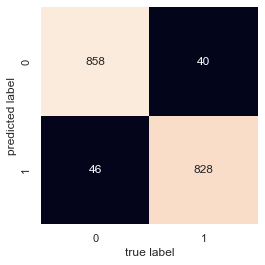

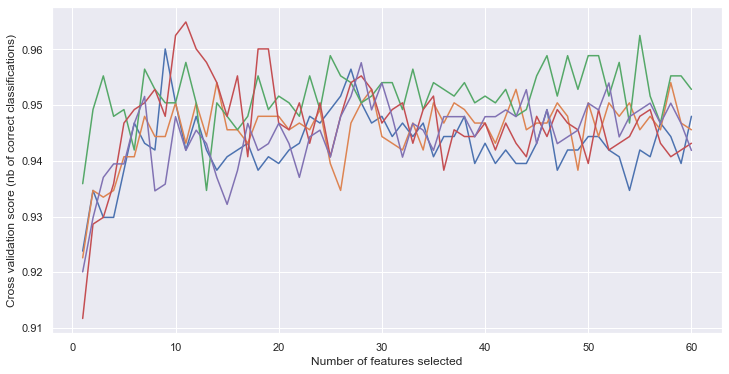

,Rank
alcohol_use,1
violence_treat_2.0,1
"age_bins_(14, 24]",1
"age_bins_(24, 34]",1
drug_punishment_3.0,1
purchase_offer_1,1
free_offer_1,1
drug_punishment_2.0,1
flavor_vap_1,1
other_vap_1,1


In [17]:
from sklearn.tree import DecisionTreeClassifier

estimator= DecisionTreeClassifier()
model = DecisionTreeClassifier()

# crosvalidation 
n_split = 5
n_repeat = 5


feature_selection(X_train_std, X_test_std, y_train, y_test, model, estimator,  n_split, n_repeat)

## RFECV LR 

Optimal number of features : 51
Accuracy: 0.921
Precision: 0.9213
Recall: 0.921
F1 Score: 0.921
Cohen Kappa Score: 0.842
Matthews Corrcoef: 0.8423
roc_auc_score: 0.9212129399290405
		Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.93      0.92       882
         1.0       0.93      0.91      0.92       890

    accuracy                           0.92      1772
   macro avg       0.92      0.92      0.92      1772
weighted avg       0.92      0.92      0.92      1772

Confusion Matrix:
 [[823  81]
 [ 59 809]]


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


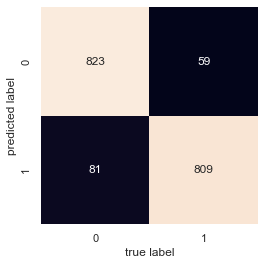

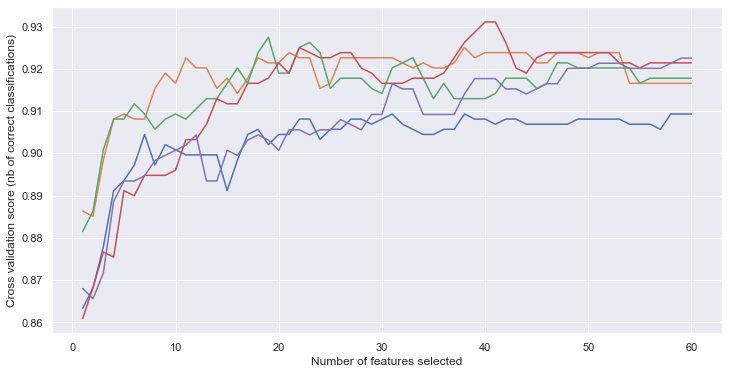

,Rank
alcohol_use,1
"age_bins_(14, 24]",1
"age_bins_(24, 34]",1
"age_bins_(44, 54]",1
"age_bins_(54, 70]",1
education_1.0,1
education_2.0,1
education_3.0,1
education_4.0,1
residency_1.0,1


In [18]:
from sklearn.linear_model import LogisticRegression

estimator= LogisticRegression(solver='lbfgs', max_iter=1000)
model = LogisticRegression(solver='lbfgs', max_iter=1000)

# crosvalidation 
n_split = 5
n_repeat = 5


feature_selection(X_train_std, X_test_std, y_train, y_test, model, estimator,  n_split, n_repeat)

## RFECV Perceptron

Optimal number of features : 57
Accuracy: 0.9458
Precision: 0.9458
Recall: 0.9458
F1 Score: 0.9458
Cohen Kappa Score: 0.8916
Matthews Corrcoef: 0.8916
roc_auc_score: 0.9458244973696016
		Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.95      0.95       902
         1.0       0.95      0.94      0.94       870

    accuracy                           0.95      1772
   macro avg       0.95      0.95      0.95      1772
weighted avg       0.95      0.95      0.95      1772

Confusion Matrix:
 [[855  49]
 [ 47 821]]


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


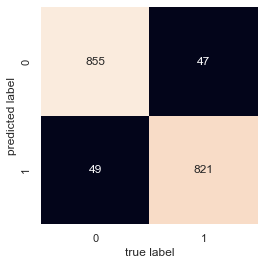

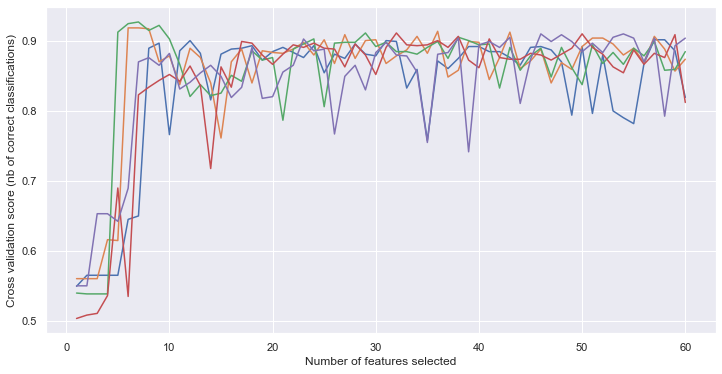

,Rank
alcohol_use,1
"age_bins_(24, 34]",1
"age_bins_(34, 44]",1
"age_bins_(44, 54]",1
"age_bins_(54, 70]",1
education_1.0,1
education_2.0,1
education_3.0,1
residency_1.0,1
residency_2.0,1


In [19]:
from sklearn.linear_model import LogisticRegression

#estimator= LogisticRegression(solver='lbfgs', max_iter=1000)
#model = LogisticRegression(solver='lbfgs', max_iter=1000)

estimator = Perceptron()
model = DecisionTreeClassifier()

# crosvalidation 
n_split = 5
n_repeat = 5


feature_selection(X_train_std, X_test_std, y_train, y_test, model, estimator,  n_split, n_repeat)

# Final Process

Our results shows that RF produces the better results with less features. To analyze it more in details and extract the features, we will conduct RFE analysis. 

## 15 Features

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
import numpy as np



In [21]:
from sklearn.ensemble import GradientBoostingClassifier
#rfe = RFE(estimator=GradientBoostingClassifier(), n_features_to_select=15)
#model = GradientBoostingClassifier()

from sklearn.ensemble import RandomForestClassifier
rfe= RFE(RandomForestClassifier(), n_features_to_select=15)
model = RandomForestClassifier(n_estimators=100, random_state=92116)




pipeline = Pipeline([('Feature Selection', rfe), ('Model', model)])
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=92116)
n_scores = cross_val_score(pipeline, X_train_std, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
np.mean(n_scores)


0.9658373990963878

In [22]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('Feature Selection',
                 RFE(estimator=RandomForestClassifier(),
                     n_features_to_select=15)),
                ('Model', RandomForestClassifier(random_state=92116))])

Accuracy: 0.9701
Precision: 0.9701
Recall: 0.9701
F1 Score: 0.9701
Cohen Kappa Score: 0.9401
Matthews Corrcoef: 0.9402
roc_auc_score: 0.9700205945923902
		Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       909
         1.0       0.97      0.97      0.97       863

    accuracy                           0.97      1772
   macro avg       0.97      0.97      0.97      1772
weighted avg       0.97      0.97      0.97      1772

Confusion Matrix:
 [[880  24]
 [ 29 839]]


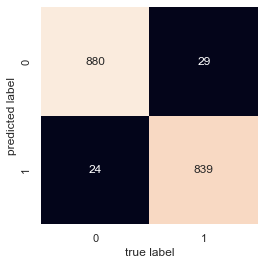

In [23]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

y_pred = pipeline.predict(X_test)

print('Accuracy:', np.round(metrics.accuracy_score(y_test, y_pred),4))
print('Precision:', np.round(metrics.precision_score(y_test, y_pred,average='weighted'),4))
print('Recall:', np.round(metrics.recall_score(y_test, y_pred,
                                               average='weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(y_test, y_pred,
                                               average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, y_pred),4))
print('Matthews Corrcoef:', np.round(metrics.matthews_corrcoef(y_test, y_pred),4)) 

from sklearn.metrics import roc_auc_score
print("roc_auc_score:", roc_auc_score(y_test, y_pred, average=None))

print('\t\tClassification Report:\n', metrics.classification_report(y_pred,y_test))


from sklearn.metrics import confusion_matrix
print("Confusion Matrix:\n",confusion_matrix(y_test, y_pred))


#Plot Confusion Matrix
from sklearn.metrics import confusion_matrix
from io import BytesIO #neded for plot
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)


plt.xlabel('true label')
plt.ylabel('predicted label');

plt.savefig("Confusion.jpg")
# Save SVG in a fake file object.
f = BytesIO()
plt.savefig(f, format="svg")

In [24]:
rfe.support_

array([ True,  True, False,  True,  True, False,  True,  True, False,
       False,  True, False, False,  True, False, False,  True, False,
       False,  True,  True,  True, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False])

In [25]:
pd.DataFrame(rfe.support_,index=data.columns[1:],columns=['Rank'])

,Rank
alcohol_use,True
nuuska,True
cigarette,False
e_cigarette,True
prob_country,True
prob_resident,False
risk_of_use,True
risk_of_try,True
cannabis_access,False
other_drug_access,False


In [26]:
rf_df = pd.DataFrame(rfe.ranking_,index=data.columns[1:],columns=['Rank']).sort_values(by='Rank',ascending=True)
rf_df

,Rank
alcohol_use,1
marriage_status_1.0,1
"age_bins_(24, 34]",1
drug_punishment_1.0,1
purchase_offer_1,1
free_offer_1,1
nicotine_vap_1,1
sport,1
intoxicant_access,1
drug_user_friend_1,1


In [27]:
# list of features for further use

dt_cloumns = rf_df[rf_df['Rank']==1].reset_index()
dt_cloumns= dt_cloumns['index'].to_list()
dt_cloumns

['alcohol_use',
 'marriage_status_1.0',
 'age_bins_(24, 34]',
 'drug_punishment_1.0',
 'purchase_offer_1',
 'free_offer_1',
 'nicotine_vap_1',
 'sport',
 'intoxicant_access',
 'drug_user_friend_1',
 'nuuska',
 'risk_of_try',
 'risk_of_use',
 'e_cigarette',
 'prob_country']

## 10 Features

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
import numpy as np



In [29]:
from sklearn.ensemble import GradientBoostingClassifier
#rfe = RFE(estimator=GradientBoostingClassifier(), n_features_to_select=15)
#model = GradientBoostingClassifier()

from sklearn.ensemble import RandomForestClassifier
rfe= RFE(RandomForestClassifier(), n_features_to_select=10)
model = RandomForestClassifier(n_estimators=100, random_state=92116)




pipeline = Pipeline([('Feature Selection', rfe), ('Model', model)])
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=92116)
n_scores = cross_val_score(pipeline, X_train_std, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
np.mean(n_scores)


0.9627403458768999

In [30]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('Feature Selection',
                 RFE(estimator=RandomForestClassifier(),
                     n_features_to_select=10)),
                ('Model', RandomForestClassifier(random_state=92116))])

Accuracy: 0.9616
Precision: 0.9617
Recall: 0.9616
F1 Score: 0.9616
Cohen Kappa Score: 0.9232
Matthews Corrcoef: 0.9233
roc_auc_score: 0.9617470739366258
		Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.97      0.96       892
         1.0       0.97      0.95      0.96       880

    accuracy                           0.96      1772
   macro avg       0.96      0.96      0.96      1772
weighted avg       0.96      0.96      0.96      1772

Confusion Matrix:
 [[864  40]
 [ 28 840]]


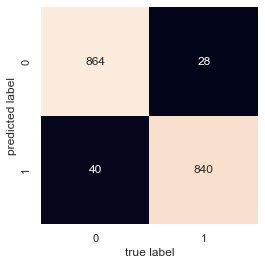

In [31]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

y_pred = pipeline.predict(X_test)

print('Accuracy:', np.round(metrics.accuracy_score(y_test, y_pred),4))
print('Precision:', np.round(metrics.precision_score(y_test, y_pred,average='weighted'),4))
print('Recall:', np.round(metrics.recall_score(y_test, y_pred,
                                               average='weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(y_test, y_pred,
                                               average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, y_pred),4))
print('Matthews Corrcoef:', np.round(metrics.matthews_corrcoef(y_test, y_pred),4)) 

from sklearn.metrics import roc_auc_score
print("roc_auc_score:", roc_auc_score(y_test, y_pred, average=None))

print('\t\tClassification Report:\n', metrics.classification_report(y_pred,y_test))


from sklearn.metrics import confusion_matrix
print("Confusion Matrix:\n",confusion_matrix(y_test, y_pred))


#Plot Confusion Matrix
from sklearn.metrics import confusion_matrix
from io import BytesIO #neded for plot
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)


plt.xlabel('true label')
plt.ylabel('predicted label');

plt.savefig("Confusion.jpg")
# Save SVG in a fake file object.
f = BytesIO()
plt.savefig(f, format="svg")

In [32]:
rfe.support_

array([ True,  True, False,  True,  True, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False])

In [33]:
pd.DataFrame(rfe.support_,index=data.columns[1:],columns=['Rank'])

,Rank
alcohol_use,True
nuuska,True
cigarette,False
e_cigarette,True
prob_country,True
prob_resident,False
risk_of_use,True
risk_of_try,True
cannabis_access,False
other_drug_access,False


In [34]:
rf_df = pd.DataFrame(rfe.ranking_,index=data.columns[1:],columns=['Rank']).sort_values(by='Rank',ascending=True)
rf_df

,Rank
alcohol_use,1
nuuska,1
free_offer_1,1
e_cigarette,1
prob_country,1
purchase_offer_1,1
risk_of_use,1
risk_of_try,1
drug_user_friend_1,1
drug_punishment_1.0,1


In [35]:
# list of features for further use

dt_cloumns = rf_df[rf_df['Rank']==1].reset_index()
dt_cloumns= dt_cloumns['index'].to_list()
dt_cloumns

['alcohol_use',
 'nuuska',
 'free_offer_1',
 'e_cigarette',
 'prob_country',
 'purchase_offer_1',
 'risk_of_use',
 'risk_of_try',
 'drug_user_friend_1',
 'drug_punishment_1.0']

# 5. Summary 

These 15 features are enough to predict cannabis use with a %96 accuracy rate. In the next stage, we will look a bit more closer to the feature and then build a prediction model. If you would like to see how the same process could be done with SHAP method, you can find that file in the main folder. 